In [1]:
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    PowerLawSpectralModel,
    CompoundSpectralModel,
)

import astropy.units as u
import numpy as np

import time
import operator

import matplotlib.pyplot as plt

In [2]:
class CompoundWithEvaluate(CompoundSpectralModel):
    
    def evaluate(self, energy, *args):
        args1 = args[:len(self.model1.parameters)]
        args2 = args[len(self.model1.parameters):]
        vals1 = self.model1.evaluate(energy, *args1)
        vals2 = self.model2.evaluate(energy, *args2)
        return self.operator(vals1, vals2)

In [3]:
nb_loops = 100
nb_points = 1000

E = np.geomspace(0.1, 10, 100) * u.TeV
index = np.linspace(1.5, 2.5, nb_points)
alpha_norm = np.linspace(0.9, 1.1, nb_points)
z = 0.3
amplitude = 1e-12 *u.cm**-2 *u.s**-1 *u.TeV**-1
reference = 1 *u.TeV

ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=z, alpha_norm=2)
ebl.parameters["alpha_norm"].frozen = False
pwl = PowerLawSpectralModel(reference=reference, index=2, amplitude=amplitude)

evaluate_model = CompoundWithEvaluate(ebl, pwl, operator.mul)
compound_model = CompoundSpectralModel(ebl, pwl, operator.mul)

In [4]:
def bench_evaluate():
    _time = time.time()
    output = None
    for _ in range(nb_loops):
        args = [z, alpha_norm, index, amplitude, reference]
        output = evaluate_model.evaluate(E[:,None], *args)
    print("Evaluate method  : {:.3f} s".format(time.time()-_time))
    return np.array(output)

def bench_compound():
    _time = time.time()
    output = None
    for _ in range(nb_loops):
        output = []
        for alp, ind in zip(alpha_norm, index):
            args = [alp, ind, amplitude.value]
            compound_model.parameters.set_parameter_factors(args)
            output.append(compound_model(E))
    print("Call on the model: {:.3f} s".format(time.time()-_time))
    return np.array(output).T

In [5]:
out_eval = bench_evaluate()
out_call = bench_compound()

Evaluate method  : 0.290 s
Call on the model: 35.547 s


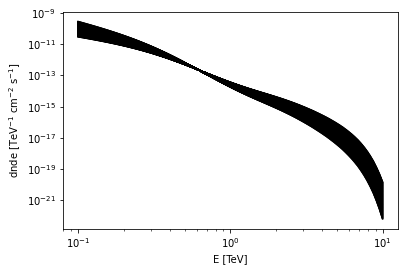

In [6]:
assert (out_eval == out_call).all()

for y in out_eval.T:
    plt.plot(E, y, color='k', alpha=0.1)
    
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"E [TeV]")
plt.ylabel(r"dnde [TeV$^{-1}$ cm$^{-2}$ s$^{-1}$]")

plt.show()